# **Ejercicio: clasificar en female / male caras en color**

La base de datos usada es un subconjunto de la base de datos
"Labeled Faces in the Wild" ("LFW"):

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

  http://vis-www.cs.umass.edu/lfw/

La separación en carpetas "female" / "male" se ha realizado usando
un código basado en:
https://github.com/Pletron/LFWgender

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import os
from PIL import Image

In [2]:
COLAB = False

Si se desea ejecutar en local:

- Descargar el dataset de: https://drive.google.com/file/d/1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei

- Poner variable COLAB a False

In [3]:
!ls -la

total 48456
drwxrwxr-x 5 tomas tomas     4096 Dec 23 14:51 .
drwxrwxr-x 8 tomas tomas     4096 Dec 23 14:51 ..
-rw-rw-r-- 1 tomas tomas    60671 Dec 23 14:45 best_model.keras
-rw-r--r-- 1 tomas tomas     3247 Mar 11  2022 caras_aux.py
-rw-rw-r-- 1 tomas tomas    37244 Dec 23 14:51 color-base.ipynb
-rw-rw-r-- 1 tomas tomas    27897 Dec 23 14:27 color-cnn.ipynb
-rw-rw-r-- 1 tomas tomas    28427 Dec 23 14:27 color-cnntl.ipynb
-rw-r--r-- 1 tomas tomas     3237 Mar 11  2022 funciones_auxiliares.py
drwxr-xr-x 4 tomas tomas     4096 Nov 11  2019 gender
-rw-rw-r-- 1 tomas tomas   435551 Dec 23 14:45 gris-base.ipynb
drwxrwxr-x 2 tomas tomas     4096 Dec 23 14:50 .ipynb_checkpoints
-rw-r--r-- 1 tomas tomas 48988160 Dec 23 14:15 .jupyter_ystore.db
drwxrwxr-x 2 tomas tomas     4096 Dec 23 14:43 __pycache__


### Descarga de datos

In [4]:
if COLAB:
    aux = "'https://drive.usercontent.google.com/download?id=1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei&export=download&confirm=t&uuid=56f4f47a-291b-4ef9-895f-8886caf14b78'"
    !wget $aux -O ./gender.zip
    !unzip -qq ./gender.zip

In [5]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1jifedd49sgZI2ZA6722h9R-mRh2Ciqzp',
                                        dest_path='./caras_aux.py.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1w6rSNy0mDds1cDNBtbL9U1bkF4PiGCnK',
                                        dest_path='./funciones_auxiliares.py.zip', unzip=True)

## **Funciones auxiliares**

In [6]:
from IPython.display import SVG
from keras.utils import model_to_dot

def display_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

2024-12-23 14:51:19.064967: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 14:51:19.072289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734961879.080171   92650 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734961879.082541   92650 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 14:51:19.091535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, figsize=(10,4)):
    best_i = np.argmax(val_acc)
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [8]:
!ls -la

total 48456
drwxrwxr-x 5 tomas tomas     4096 Dec 23 14:51 .
drwxrwxr-x 8 tomas tomas     4096 Dec 23 14:51 ..
-rw-rw-r-- 1 tomas tomas    60671 Dec 23 14:45 best_model.keras
-rw-r--r-- 1 tomas tomas     3247 Mar 11  2022 caras_aux.py
-rw-rw-r-- 1 tomas tomas    37244 Dec 23 14:51 color-base.ipynb
-rw-rw-r-- 1 tomas tomas    27897 Dec 23 14:27 color-cnn.ipynb
-rw-rw-r-- 1 tomas tomas    28427 Dec 23 14:27 color-cnntl.ipynb
-rw-r--r-- 1 tomas tomas     3237 Mar 11  2022 funciones_auxiliares.py
drwxr-xr-x 4 tomas tomas     4096 Nov 11  2019 gender
-rw-rw-r-- 1 tomas tomas   435551 Dec 23 14:45 gris-base.ipynb
drwxrwxr-x 2 tomas tomas     4096 Dec 23 14:50 .ipynb_checkpoints
-rw-r--r-- 1 tomas tomas 48988160 Dec 23 14:15 .jupyter_ystore.db
drwxrwxr-x 2 tomas tomas     4096 Dec 23 14:43 __pycache__


## **Exploración de datos**

In [9]:
def loadImages_color(root, factor=1, nimages=False, color=False):
    files = os.listdir(root)
    if not nimages:
        nimages = len(files)
    if not color:
        X = np.zeros((nimages, int(factor*250)*int(factor*250)))
    else:
        X = np.zeros((nimages, 3*int(factor*250)*int(factor*250)))
    for i in range(nimages):
        f = os.path.join(root, files[i])
        if not color:
            img = Image.open(f).convert('L')
        else:
            img = Image.open(f)
        dims = np.shape(img)
        if i==0:
            h = int(factor*dims[0])
            w = int(factor*dims[1])
        img = img.resize((h, w))
        X[i,:] = np.ravel(img)
    return X, h, w


Estadísticas básicas de la base de datos leída:
  # clases: 2
  # patrones: 2000
  # atributos (features): 7500

Algunas imágenes de la clase "female":


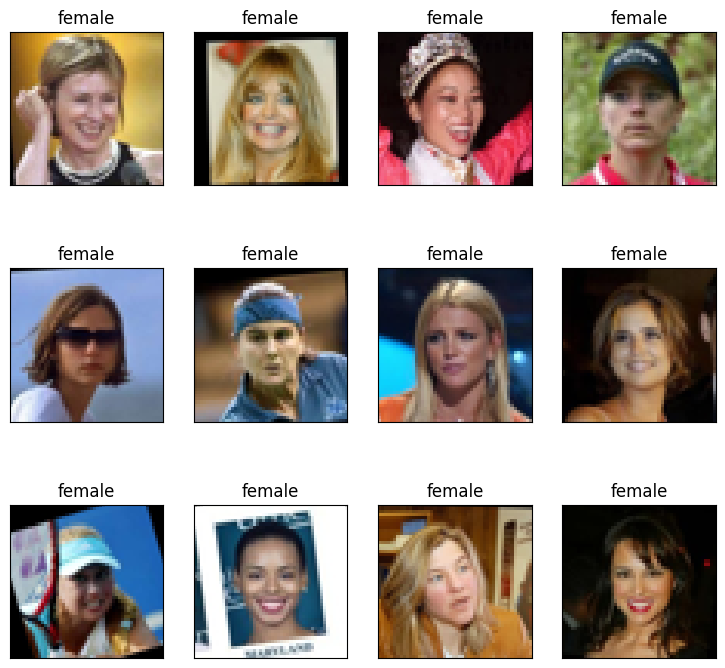


Algunas imágenes de la clase "male":


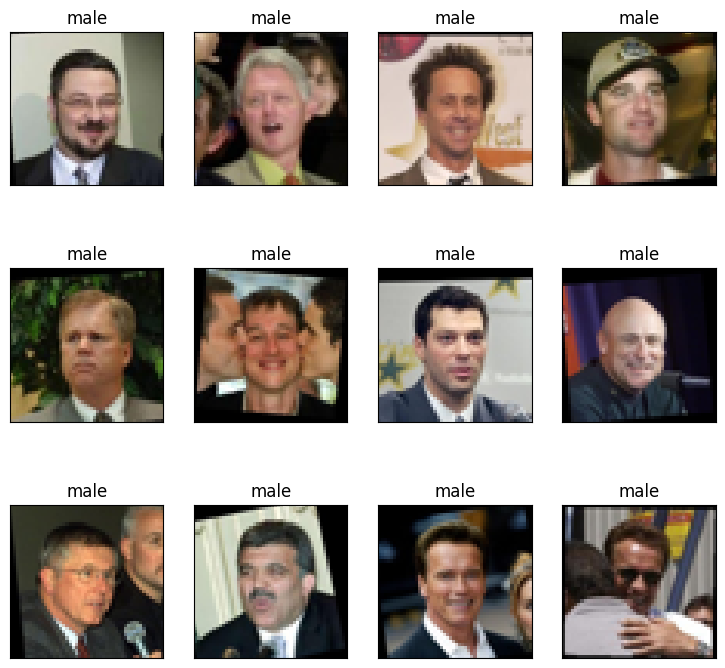

In [10]:
from caras_aux import plot_gallery

# cargo las imágenes y preparo los datos que se van a usar
factor = 0.2 # factor de reducción de resolución de las imágenes, debe ser
             # >0 y <=1 (en cuyo caso la resolución es la original, 250x250)
X_clase0, height, width = loadImages_color('./gender/female',
                                           factor=factor, nimages=1000,
                                           color=True)
X_clase1, height, width = loadImages_color('./gender/male',
                                           factor=factor, nimages=1000,
                                           color=True)
X = np.concatenate((X_clase0, X_clase1))
n_samples, n_features = X.shape

target_names = np.array(['female', 'male'])
n_classes = len(target_names)
N0 = len(X_clase0); N1 = len(X_clase1)
y = N0*[0] + N1*[1]
y = np.array(y)

print('\nEstadísticas básicas de la base de datos leída:')
print('  # clases: %d' % n_classes)
print('  # patrones: %d' % n_samples)
print('  # atributos (features): %d' % n_features)

cmap = None
X_aux0 = X_clase0[:12].reshape((12, height, width, 3)).astype(int)
X_aux1 = X_clase1[:12].reshape((12, height, width, 3)).astype(int)

print('\nAlgunas imágenes de la clase "female":')
plot_gallery(X_aux0, 12*['female'], cmap=cmap)
print('\nAlgunas imágenes de la clase "male":')
plot_gallery(X_aux1, 12*['male'], cmap=cmap);

In [11]:
#np.sqrt(4107/3)

In [12]:
print(np.shape(X)); print(np.shape(y)); print(X)

(2000, 7500)
(2000,)
[[130.  84.  27. ... 175. 146. 137.]
 [  0.   0.   0. ...   0.   0.   0.]
 [ 14.   8.   8. ...  10.   1.   2.]
 ...
 [ 24.  18.   9. ... 209. 192. 228.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...  70.  74.  57.]]


In [13]:
X.min(), X.max()

(np.float64(0.0), np.float64(255.0))

### Normalización de datos

In [14]:
X /= 255 #  equivalente a: X = X / 255

In [15]:
X.min(), X.max()

(np.float64(0.0), np.float64(1.0))

Ahora seguimos entendiendo la estructura de los datos:

In [16]:
y.shape

(2000,)

In [17]:
np.unique(y)

array([0, 1])

In [18]:
X.shape

(2000, 7500)

In [19]:
X.shape[1] / 3 # ahora por cada píxel tenemos 3 valores: R, G, B (la imagen es a color)

2500.0

In [20]:
np.sqrt(X.shape[1] / 3) # lado de la imagen

np.float64(50.0)

### **Partición training-test**

In [21]:
from sklearn.model_selection import train_test_split

# divido en conjuntos de training y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=200,
                                                    random_state=42,
                                                    stratify=y)

Parto el conjunto de training en tr (training final) y validación:

In [22]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size=0.3,
                                            random_state=1,
                                            stratify=y_train)

Finalmente tengo los siguientes conjuntos:

- **X_tr:** conjunto con el que entreno la red
- **X_val:** conjunto con el que monitorizo la red mientras se entrena
- **X_test:** conjunto de test final

 Chequeo de las dimensiones de estos conjuntos:

In [23]:
X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1260, 7500), (1260,), (540, 7500), (540,), (200, 7500), (200,))

Parece que están bien:

- La primera dimensión de X_tr e y_tr es igual
- La primera de X_val e y_val también
- La primera de X_test e y_test también
- La segunda dimensión de X_tr, X_val, X_test es 5625 (número total de píxels)

### **Estadísticas de las clases**

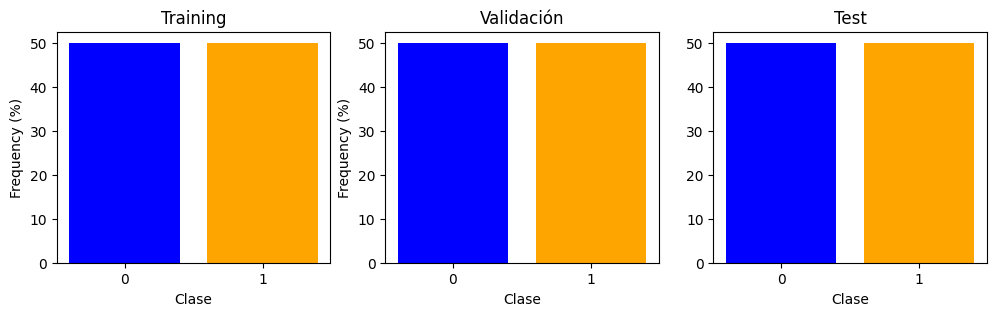

- Priori de la clase 0 en training: 0.500
- Priori de la clase 1 en training: 0.500
- Clase mayoritaria en training: 0

- Priori de la clase 0 en test: 0.500
- Priori de la clase 1 en test: 0.500
- Score de la clasificacion por mayoria en test: 0.500


In [24]:
from caras_aux import report_base_error

plt.figure(figsize=(12,3))
ax = plt.subplot(1,3,1)
clases, counts = np.unique(y_tr, return_counts=True)
plt.bar(clases, 100*counts/len(y_tr), color=["blue", "orange"])
plt.title('Training'); plt.xlabel('Clase'); plt.ylabel('Frequency (%)'); ax.set_xticks(clases)

ax = plt.subplot(1,3,2)
clases, counts = np.unique(y_val, return_counts=True)
plt.bar(clases, 100*counts/len(y_val), color=["blue", "orange"])
plt.title('Validación'); plt.xlabel('Clase'); plt.ylabel('Frequency (%)'); ax.set_xticks(clases)

ax = plt.subplot(1,3,3)
none, counts = np.unique(y_test, return_counts=True)
plt.bar(clases, 100*counts/len(y_test), color=["blue", "orange"])
plt.title('Test'); plt.xlabel('Clase'); ax.set_xticks(clases); plt.show()

report_base_error(X_tr, y_tr, X_test, y_test)

## **Modelo de referencia**

In [25]:
# Regresión logística:

from sklearn.linear_model import LogisticRegression
model0 = LogisticRegression(max_iter=1000, C=0.01) # C: factor de regularización. Cuanto más bajo, más "poda" (al revés que en Keras)
model0.fit(X_tr, y_tr)

LogisticRegression(C=0.01, max_iter=1000)

Scores en training, validación y test:

In [26]:
model0.score(X_tr, y_tr), model0.score(X_val, y_val), model0.score(X_test, y_test)

(0.8873015873015873, 0.7685185185185185, 0.78)

In [27]:
probs_test = model0.predict_proba(X_test)
probs_test[:5]

array([[0.87205958, 0.12794042],
       [0.66805899, 0.33194101],
       [0.18501203, 0.81498797],
       [0.53416201, 0.46583799],
       [0.33458555, 0.66541445]])

In [28]:
probs_test_male = probs_test[:,1] # segunda columna

In [29]:
from funciones_auxiliares import analisis_roc, plot_confusion_matrix

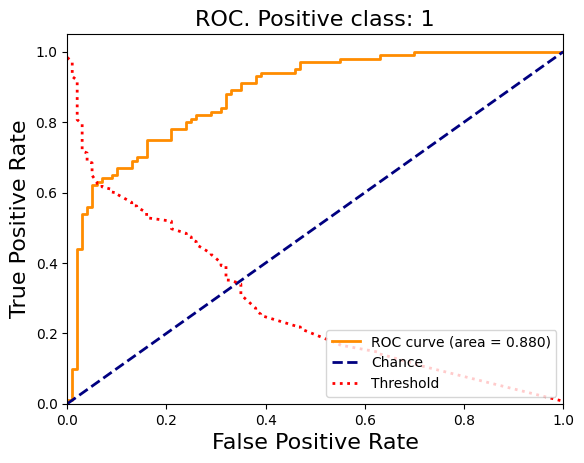

In [30]:
analisis_roc(y=y_test, positive_class_scores=probs_test_male, POSITIVE_CLASS=1)

In [31]:
TPR = sum(y_test[probs_test_male > 0.6]) / sum(y_test) # famosos detectados / famosos totales
FPR = sum(y_test[probs_test_male > 0.6]!=1) / sum(y_test!=1)
TPR, FPR

(np.float64(0.65), np.float64(0.09))

In [32]:
alarmas = probs_test_male > 0
y_test[alarmas]

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1])

In [33]:
# clases predichas en test:

predicciones_test = model0.predict(X_test)
predicciones_test[:5]

array([0, 0, 1, 0, 1])

Confusion matrix, without normalization
[[79 21]
 [23 77]]


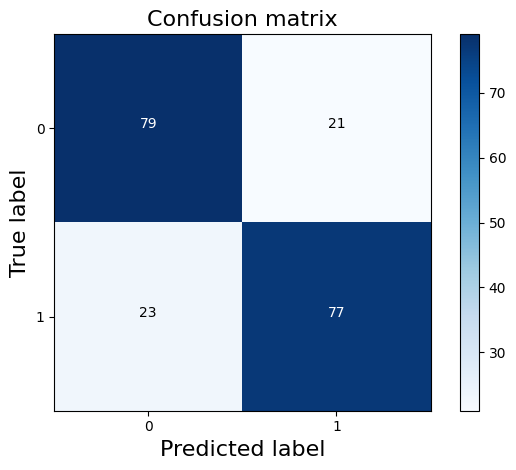

In [34]:
plot_confusion_matrix(y=y_test, y_pred=predicciones_test)

## **Implementación en Keras de un modelo que clasifique una cara en color en female / male**

In [35]:
X.shape

(2000, 7500)

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import L1, L2, L1L2
from keras import optimizers

model = Sequential()


model.compile(loss="binary_crossentropy",
              #optimizer=optimizers.RMSprop(0.0001),
              metrics=["accuracy"])

I0000 00:00:1734961882.542919   92650 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
display_model(model)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

## **Entrenamiento del modelo**

In [39]:
from keras.callbacks import ModelCheckpoint

serie_tr_acc = []
serie_val_acc = []
serie_tr_loss  = []
serie_val_loss = []

epochs = 500

modelpath="best_model.keras"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [40]:
from IPython.display import clear_output

In [41]:
for e in range(epochs):
    history = model.fit(X_tr, y_tr, epochs=1, batch_size=32, callbacks=callbacks_list,
                        verbose=10, validation_data=(X_val,y_val))

    serie_tr_acc.append(history.history['accuracy'][0])
    serie_val_acc.append(history.history['val_accuracy'][0])
    serie_tr_loss.append(history.history['loss'][0])
    serie_val_loss.append(history.history['val_loss'][0])

    if len(serie_tr_acc) % 2 == 0:
        clear_output()
    grafica_entrenamiento(serie_tr_acc, serie_val_acc, serie_tr_loss, serie_val_loss)

ValueError: Sequential model sequential cannot be built because it has no layers. Call `model.add(layer)`.

Recupero el mejor modelo (punto rojo), que está grabado en el fichero dado por la variable modelpath:

In [ ]:
modelpath

In [ ]:
from keras.models import load_model

model = load_model(modelpath)

## **Análisis de los resultados del modelo**

In [ ]:
probs_predicciones_test = model.predict(X_test).flatten()
probs_predicciones_test[:5]

**Score (tasa de acierto, "accuracy") en test:**

In [ ]:
predicciones_test = np.round(probs_predicciones_test)

np.mean(y_test == predicciones_test)

Score en training:

In [ ]:
np.mean(y_tr == np.round(model.predict(X_tr).flatten()))

Score en validación:

In [ ]:
np.mean(y_val == np.round(model.predict(X_val).flatten()))

In [ ]:
analisis_roc(y=y_test, positive_class_scores=probs_predicciones_test, POSITIVE_CLASS=1)

In [ ]:
plot_confusion_matrix(y=y_test, y_pred=predicciones_test)